# Stereo camera calibration

This code used dot board for calibration

    - The default numbers of dot on x-axis, y-axis are 7
    - The distance between the dots are 15 mm
    
This code in total contains 3 tasks

    - Stereo calibration
    - Intrinsic parameters estimation
    - Reduce distortion and calculate depth

https://www.cse.usf.edu/~r1k/MachineVisionBook/MachineVision.files/MachineVision_Chapter12.pdf

### Taks 1: stereo calibration

In [11]:
import cv2

import matplotlib.pyplot as plt # plt for plotting
import matplotlib.image as mpimg # mpimg for reading im
 
import sys
import numpy as np
import glob


In [15]:
class StereoCam:
    def __init__(self):
        self.m1 = 0
        self.m2 = 0
        self.d1 = 0
        self.d2 = 0
        self.R = 0
        self.T = 0
        
        self.cam_matrix_left = None
        self.cam_matrix_right = None
        self.distortion_l = None
        self.distortion_r = None
    
    #convert parameters to matrix 
    def convert2mat(self):
        #intrinsics for left camera
        self.cam_matrix_left = self.m1
        #intrinsics for right camera
        self.cam_matrix_right = self.m2

        #The distrotion parameters:[k1, k2, p1, p2, k3]
        self.distortion_l = self.d1
        self.distortion_r = self.d2

        #Rotattion matrix
        self.R 
#         self.R = np.array([[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]])
        #Translation matrix
        self.T 
#        self.T = np.array([[-293.835],
#                         [  -7.334],
#                         [  52.816]])

        self.baseline = self.T[0]
        

['images/camL/L1.bmp', 'images/camL/L10.bmp', 'images/camL/L11.bmp', 'images/camL/L12.bmp', 'images/camL/L13.bmp', 'images/camL/L14.bmp', 'images/camL/L15.bmp', 'images/camL/L16.bmp', 'images/camL/L17.bmp', 'images/camL/L18.bmp', 'images/camL/L19.bmp', 'images/camL/L2.bmp', 'images/camL/L20.bmp', 'images/camL/L3.bmp', 'images/camL/L4.bmp', 'images/camL/L5.bmp', 'images/camL/L6.bmp', 'images/camL/L7.bmp', 'images/camL/L8.bmp', 'images/camL/L9.bmp']
['images/camR/R1.bmp', 'images/camR/R10.bmp', 'images/camR/R11.bmp', 'images/camR/R12.bmp', 'images/camR/R13.bmp', 'images/camR/R14.bmp', 'images/camR/R15.bmp', 'images/camR/R16.bmp', 'images/camR/R17.bmp', 'images/camR/R18.bmp', 'images/camR/R19.bmp', 'images/camR/R2.bmp', 'images/camR/R20.bmp', 'images/camR/R3.bmp', 'images/camR/R4.bmp', 'images/camR/R5.bmp', 'images/camR/R6.bmp', 'images/camR/R7.bmp', 'images/camR/R8.bmp', 'images/camR/R9.bmp']
True


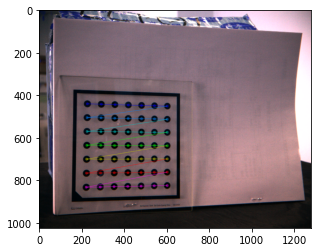

True


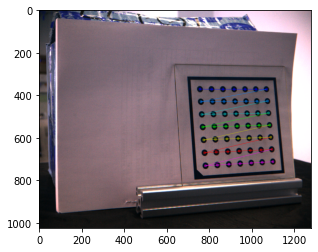

True


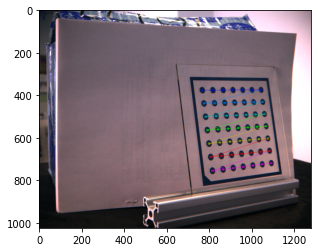

True


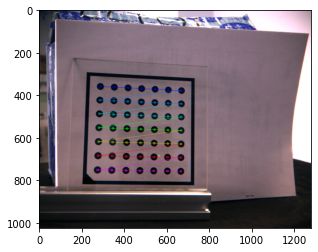

True


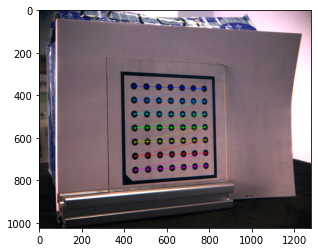

True


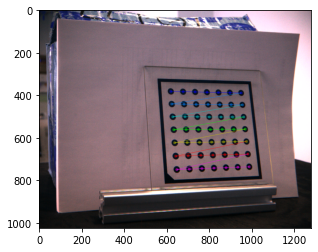

True


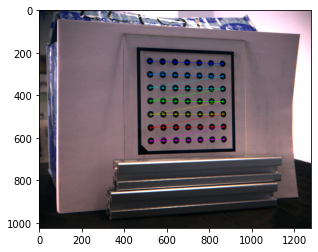

True


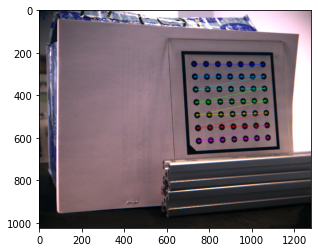

True


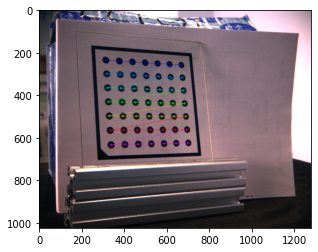

True


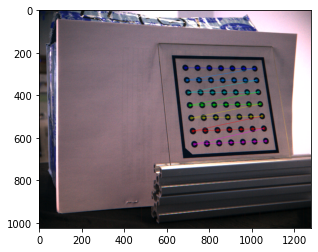

True


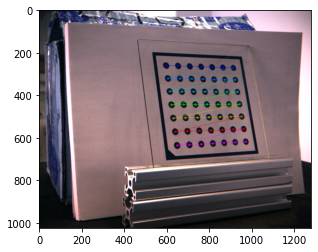

True


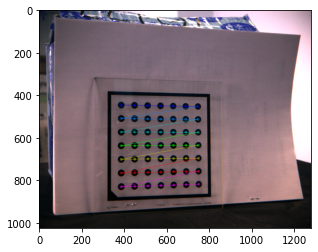

True


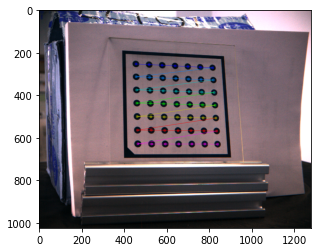

True


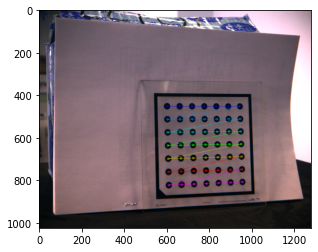

True


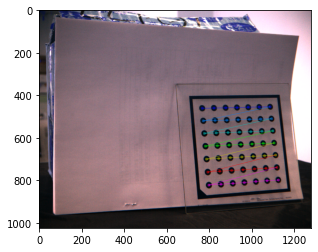

True


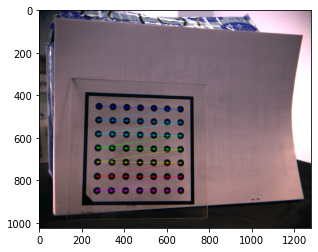

True


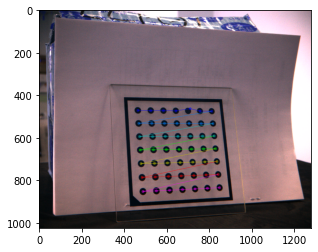

False
True


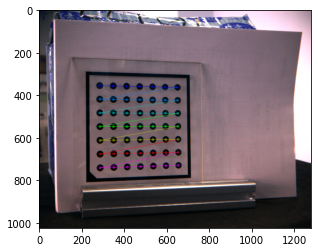

True


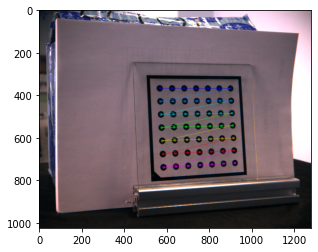

total error:  0.02552895315013799
total error:  0.028725163900975837
ml_v2 =  [[2158.66435    0.       663.3482 ]
 [   0.      2158.75331  521.60097]
 [   0.         0.         1.     ]]
mr_v2 =  [[2156.96974    0.       609.71291]
 [   0.      2158.65266  532.00808]
 [   0.         0.         1.     ]]
dl =  [[ -0.03706   1.35135   0.00024   0.00197 -10.94371]]
dr =  [[ 0.00666 -0.49887  0.00156  0.00093  8.74557]]
R: [[ 0.85431 -0.00472  0.51974]
 [ 0.00609  0.99998 -0.00094]
 [-0.51972  0.00397  0.85432]]
T: [[-289.43628]
 [  -6.46068]
 [  52.29194]]


In [16]:
class StereoCalibration(object):
    def __init__(self, ims_pth='images/'):
        self.imagesL = self.read_images(ims_pth+'camL')
        self.imagesR = self.read_images(ims_pth+'camR')
        self.stereo = StereoCam()
        
    def read_images(self , cal_path):
        filepath = glob.glob(cal_path + '/*.bmp')
        filepath.sort()
        print(filepath)
        return filepath
    
    def calibration_photo(self):
        #Set the numbers of dots on dot board
        x_nums = 7      #dots on x axis
        y_nums = 7      #dots on y axis
        
        # Gnereate the board's coordinates in world frame 
        world_point = np.zeros((x_nums * y_nums,3),np.float32)            #generate x_nums*y_nums coordinates，each contains <x,y,z>
        world_point[:,:2] = np.mgrid[:x_nums,:y_nums].T.reshape(-1, 2)    #mgrid[]generate 2d matrix，each shape is [x_num, y_num]
                                                                          #.T for transpose
                                                                          
        #buffers for saving positions
        world_position = []
        image_positionl = []
        image_positionr = []
        
        #set the constrain for estimation
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,30,0.001)
        
        #get all images
        for ii in range(20):

            image_path_l = self.imagesL[ii]
            image_path_r = self.imagesR[ii]

            image_l = cv2.imread(image_path_l)
            image_r = cv2.imread(image_path_r)
            gray_l = cv2.cvtColor(image_l,cv2.COLOR_RGB2GRAY)
            gray_r = cv2.cvtColor(image_r,cv2.COLOR_RGB2GRAY)

            #find the feature dot in the images
            ok1,cornersl = cv2.findCirclesGrid(gray_l,(x_nums,y_nums),None)
            ok2,cornersr = cv2.findCirclesGrid(gray_r,(x_nums,y_nums),None)
            
            """ if using chessboard instead of dotboard
            ok1,cornersl = cv2.findChessboardCorners(gray_l,(x_nums,y_nums),None)
            ok2,cornersr = cv2.findChessboardCorners(gray_r,(x_nums,y_nums),None)
            """
            
            self.world = world_point
            
            print("feature found:", ok1&ok2)
            
            if ok1&ok2:
                #world_position
                center_spacing = 15     # the distance between the dots, unit mm
                world_position.append(world_point*center_spacing)
                #get more accurate pix coordinates
                exact_cornersl = cv2.cornerSubPix(gray_l,cornersl,(11,11),(-1,-1),criteria)
                exact_cornersr = cv2.cornerSubPix(gray_r,cornersr,(11,11),(-1,-1),criteria)
                #put the coordinates into image_position
                image_positionl.append(exact_cornersl)
                image_positionr.append(exact_cornersr)
                #visualiza the corners
                image = cv2.drawChessboardCorners(image_l,(x_nums,y_nums),exact_cornersl,ok1)
                plt.imshow(image)
                plt.show()
    
        #separately calculate the intrinsic parameters
        image_shape = gray_l.shape[::-1]
        
        retl, mtxl, distl, rvecsl, tvecsl = cv2.calibrateCamera(world_position, image_positionl, image_shape , None,None)
        retr, mtxr, distr, rvecsr, tvecsr = cv2.calibrateCamera(world_position, image_positionr, image_shape , None,None)
        
        self.cal_error(world_position , image_positionl ,  mtxl , distl , rvecsl , tvecsl)
        self.cal_error(world_position , image_positionr ,  mtxr,  distr , rvecsr , tvecsr)

        self.stereo_calibrate( world_position ,image_positionl , image_positionr , mtxl, distl, mtxr, distr, image_shape)
        
    def cal_error(self , world_position , image_position ,  mtx , dist , rvecs , tvecs):
        mean_error = 0
        for i in range(len(world_position)):
            image_position2, _ = cv2.projectPoints(world_position[i], rvecs[i], tvecs[i], mtx, dist)
            error = cv2.norm(image_position[i], image_position2, cv2.NORM_L2) / len(image_position2)
            mean_error += error
        print("total error: ", mean_error / len(image_position))

    def stereo_calibrate( self ,  objpoints, imgpoints_l, imgpoints_r, M1, d1, M2, d2, dims):
        flags = 0
        flags |= cv2.CALIB_FIX_INTRINSIC
        flags |= cv2.CALIB_USE_INTRINSIC_GUESS
        flags |= cv2.CALIB_FIX_FOCAL_LENGTH
        flags |= cv2.CALIB_ZERO_TANGENT_DIST
        stereocalib_criteria = (cv2.TERM_CRITERIA_MAX_ITER +cv2.TERM_CRITERIA_EPS, 100, 1e-5)
        ret, M1, d1, M2, d2, R, T, E, F = cv2.stereoCalibrate(
                                    objpoints, imgpoints_l,
                                    imgpoints_r, M1, d1, M2,
                                    d2, dims,
                                    criteria=stereocalib_criteria, flags=flags)
        print('ml_v2 = ',M1)
        print('mr_v2 = ',M2)
        print('dl = ' , d1)
        print('dr = ' , d2)
        print('R:', R)
        print('T:', T)
        self.stereo.R = R
        self.stereo.T = T
        self.stereo.m1 = M1
        self.stereo.m2 = M2
        self.stereo.d1 = d1
        self.stereo.d2 = d2
         
        
if __name__ == '__main__':
    np.set_printoptions(precision=5, suppress=True)
    # using calibration to calculate parameters
    calib = StereoCalibration()
    calib.calibration_photo()
    
    # set class for storing parameters
    stereo = calib.stereo

### Step2: Convert the previous calculated camera parameters

In [17]:
# convert the intrinsics+extrinsics to matirx, for later usage
stereo.convert2mat()

R1 =  [[ 0.93301  0.01661  0.35946]
 [-0.01514  0.99986 -0.0069 ]
 [-0.35953  0.001    0.93313]]
R1 =  [[ 0.98383  0.02196 -0.17775]
 [-0.02124  0.99976  0.00594]
 [ 0.17783 -0.00207  0.98406]]
P1 =  [[2158.70299    0.      -246.26813    0.     ]
 [   0.      2158.70299  529.43428    0.     ]
 [   0.         0.         1.         0.     ]]
P2 =  [[   2158.70299       0.         1036.14186 -635075.39751]
 [      0.         2158.70299     529.43428       0.     ]
 [      0.            0.            1.            0.     ]]
1280 1024


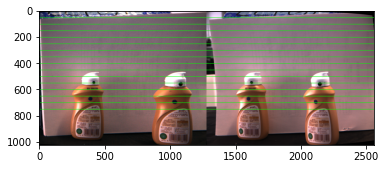

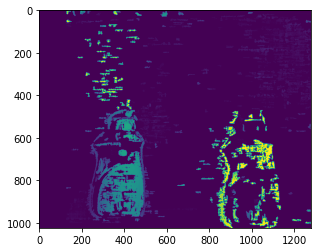

In [19]:
# convert image to gray and equalization for feature extraction
def preprocess(img1, img2):
    im1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    im2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
 
    im1 = cv2.equalizeHist(im1)
    im2 = cv2.equalizeHist(im2)
 
    return im1, im2

# eliminate the distortion
def undistortion(image, camera_matrix, dist_coeff):
    undistortion_image = cv2.undistort(image, camera_matrix, dist_coeff)
 
    return undistortion_image

# Obtain the mapping transformation matrix and reprojection matrix 
# for distortion correction and stereo correction
# @param：config is a class which stores the stereo parameters，config = stereoconfig.stereoCamera()

def getRectifyTransform(height, width, config):
    # read intrinsics and extrinsics
    left_K = config.cam_matrix_left
    right_K = config.cam_matrix_right
    left_distortion = config.distortion_l
    right_distortion = config.distortion_r
    R = config.R
    T = config.T
# #     
#     R = np.transpose(config.R)
#     T = -np.dot(np.transpose(config.R),config.T)

    # Calculate the correction transformation 
    height = int(height)
    width = int(width)
    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(left_K, left_distortion, right_K, right_distortion, (width, height), R, T,flags=0, alpha=-1)
    print('R1 = ',R1)
    print('R1 = ',R2)
    print('P1 = ',P1)
    print('P2 = ',P2)
    

#     map1x, map1y = cv2.initUndistortRectifyMap(left_K, left_distortion, R1, P1, (width, height), cv2.CV_16SC2)
#     map2x, map2y = cv2.initUndistortRectifyMap(right_K, right_distortion, R2, P2, (width, height), cv2.CV_16SC2)
    map1x, map1y = cv2.initUndistortRectifyMap(left_K, left_distortion, R1, P1, (width, height), cv2.CV_32FC1)
    map2x, map2y = cv2.initUndistortRectifyMap(right_K, right_distortion, R2, P2, (width, height), cv2.CV_32FC1)
    
    print(width,height)
 
    return map1x, map1y, map2x, map2y, Q
 
 
   # Distortion correction and stereo correction
def rectifyImage(image1, image2, map1x, map1y, map2x, map2y):
    rectifyed_img1 = cv2.remap(image1, map1x, map1y, cv2.INTER_LINEAR)
    rectifyed_img2 = cv2.remap(image2, map2x, map2y, cv2.INTER_LINEAR)
 
    return rectifyed_img1, rectifyed_img2

# Stereo Correction Inspection-Line Drawing
def draw_line1(image1, image2):
    height = max(image1.shape[0], image2.shape[0])
    width = image1.shape[1] + image2.shape[1]
    
    output = np.zeros((height, width,3), dtype=np.uint8)
    output[0:image1.shape[0], 0:image1.shape[1]] = image1
    output[0:image2.shape[0], image1.shape[1]:] = image2
 
    for k in range(15):
        cv2.line(output, (0, 50 * (k + 1)), (2 * width, 50 * (k + 1)), (0, 255, 0), thickness=2, lineType=cv2.LINE_AA)  # 直线间隔：100
 
    return output

# Stereo Correction Inspection-Line Drawing 2
def draw_line2(image1, image2):
    height = max(image1.shape[0], image2.shape[0])
    width = image1.shape[1] + image2.shape[1]
    
    output = np.zeros((height, width), dtype=np.uint8)
    output[0:image1.shape[0], 0:image1.shape[1]] = image1
    output[0:image2.shape[0], image1.shape[1]:] = image2
 
    for k in range(15):
        cv2.line(output, (0, 50 * (k + 1)), (2 * width, 50 * (k + 1)), (0, 255, 0), thickness=2, lineType=cv2.LINE_AA)  # 直线间隔：100
 
    return output

# Parallax calculation
def disparity_SGBM(left_image, right_image, down_scale=False):
    # SGBM paramters settup
    if left_image.ndim == 2:
        img_channels = 1
    else:
        img_channels = 3
    blockSize = 3
    param = {'minDisparity': 0,
             'numDisparities': 128,
             'blockSize': blockSize,
             'P1': 8 * img_channels * blockSize ** 2,
             'P2': 32 * img_channels * blockSize ** 2,
             'disp12MaxDiff': 1,
             'preFilterCap': 63,
             'uniquenessRatio': 15,
             'speckleWindowSize': 100,
             'speckleRange': 2,
             'mode': cv2.STEREO_SGBM_MODE_SGBM_3WAY
             }
 
    sgbm = cv2.StereoSGBM_create(**param)
    
    # Calculate the disparity map
    size = (left_image.shape[1], left_image.shape[0])
    if down_scale == False:
        disparity_left = sgbm.compute(left_image, right_image)
        disparity_right = sgbm.compute(right_image, left_image)
    else:
        left_image_down = cv2.pyrDown(left_image)
        right_image_down = cv2.pyrDown(right_image)
        factor = size[0] / left_image_down.shape[1]
        disparity_left_half = sgbm.compute(left_image_down, right_image_down)
        disparity_right_half = sgbm.compute(right_image_down, left_image_down)
        disparity_left = cv2.resize(disparity_left_half, size, interpolation=cv2.INTER_AREA) 
        disparity_right = cv2.resize(disparity_right_half, size, interpolation=cv2.INTER_AREA)
        disparity_left *= factor 
        disparity_right *= factor
 
    return disparity_left, disparity_right


if __name__ == '__main__':
    
    imgL = cv2.imread("images/pingzi_L.bmp")
    imgR = cv2.imread("images/pingzi_R.bmp")
#     imgL = cv2.imread("camL/L3.bmp")
#     imgR = cv2.imread("camR/R3.bmp")
#     imgL , imgR = preprocess(imgL ,imgR )

    
    
    height, width = imgL.shape[0:2]
    config = stereo    # Read camera internal and external parameters
    
    # undistortion
    imgL = undistortion(imgL ,config.cam_matrix_left , config.distortion_l )
    imgR = undistortion(imgR ,config.cam_matrix_right, config.distortion_r )
    
    # Geometric polar alignment (some problems maybe)
    map1x, map1y, map2x, map2y, Q = getRectifyTransform(height, width, config)
    iml_rectified, imr_rectified = rectifyImage(imgL, imgR, map1x, map1y, map2x, map2y)
    linepic = draw_line1(iml_rectified , imr_rectified)
#     plt.imshow(imgL)
#     plt.show()
#     plt.imshow(iml_rectified)
#     plt.show()
#     plt.imshow(imr_rectified)
#     plt.show()
    plt.imshow(linepic)
    plt.show()


    lookdispL,lookdispR = disparity_SGBM(iml_rectified  , imr_rectified )
    linepic2 = draw_line2(lookdispL,lookdispR)
    
    plt.imshow(lookdispL)    
# #     points_3d = cv2.reprojectImageTo3D(lookdispL, Q)

 

computing SGNM_disparity...


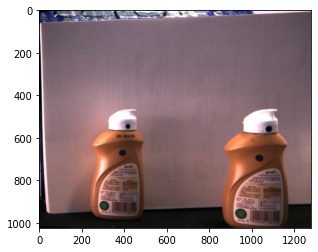

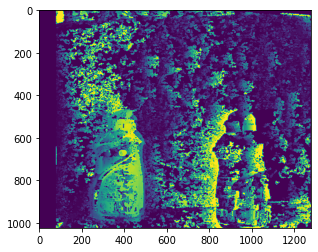

In [20]:
import numpy as np
import cv2
import time
def SGBM_update(val=0):
    global SGBM_num
    global SGBM_blockSize
    SGBM_blockSize=cv2.getTrackbarPos('blockSize', 'SGNM_disparity')
    if SGBM_blockSize % 2 == 0:
        SGBM_blockSize += 1
    if SGBM_blockSize < 5:
        SGBM_blockSize = 5
    SGBM_stereo.setBlockSize(SGBM_blockSize)
    SGBM_num=cv2.getTrackbarPos('num_disp', 'SGNM_disparity')
    num_disp = SGBM_num * 16
    SGBM_stereo.setNumDisparities(num_disp)

    SGBM_stereo.setUniquenessRatio(cv2.getTrackbarPos('unique_Ratio', 'SGNM_disparity'))
    SGBM_stereo.setSpeckleWindowSize(cv2.getTrackbarPos('spec_WinSize', 'SGNM_disparity'))
    SGBM_stereo.setSpeckleRange(cv2.getTrackbarPos('spec_Range', 'SGNM_disparity'))
    SGBM_stereo.setDisp12MaxDiff(cv2.getTrackbarPos('disp12MaxDiff', 'SGNM_disparity'))

    print('computing SGNM_disparity...')
    displ = imgR
    displ = SGBM_stereo.compute(imgL, imgR).astype(np.float32) / 16.0
    dispr = SGBM_stereo.compute(imgR, imgL).astype(np.float32) / 16.0


    return displ,dispr
#     cv2.imshow('left', imgL)
#     cv2.imshow('right', imgR)
#     cv2.imshow('SGNM_disparity', (disp - min_disp) / num_disp)

if __name__ == "__main__":
#     start = time.clock()
    SGBM_blockSize = 5
    SGBM_num=5
    min_disp = 0   
    num_disp =SGBM_num * 16      
    #blockSize = blockSize 
    uniquenessRatio = 6 
    speckleRange = 10 
    speckleWindowSize = 100
    disp12MaxDiff = 200 
    P1 = 600  
    P2 = 240

#     imgL = cv2.imread('im2.ppm')
#     imgR = cv2.imread('im6.ppm')
    imgL = iml_rectified;
    imgR = imr_rectified;

    cv2.namedWindow('SGNM_disparity')
    cv2.createTrackbar('blockSize', 'SGNM_disparity', SGBM_blockSize, 21, SGBM_update)
    cv2.createTrackbar('num_disp', 'SGNM_disparity', SGBM_num, 20, SGBM_update)
    cv2.createTrackbar('spec_Range', 'SGNM_disparity', speckleRange, 50, SGBM_update)#设置trackbar来调节参数
    cv2.createTrackbar('spec_WinSize', 'SGNM_disparity', speckleWindowSize, 200, SGBM_update)
    cv2.createTrackbar('unique_Ratio', 'SGNM_disparity', uniquenessRatio, 50, SGBM_update)
    cv2.createTrackbar('disp12MaxDiff', 'SGNM_disparity', disp12MaxDiff, 250, SGBM_update)

    SGBM_stereo = cv2.StereoSGBM_create(
        minDisparity = min_disp,  
        numDisparities = num_disp,  
        blockSize=SGBM_blockSize,  
        uniquenessRatio=uniquenessRatio, 
        speckleRange=speckleRange, 
        speckleWindowSize=speckleWindowSize,
        disp12MaxDiff=disp12MaxDiff, 
        P1=P1, 
        P2=P2
    )
    displ,dispr = SGBM_update()
    
    plt.imshow( (imgL))
    plt.show()
#     plt.imshow( (imgR))
#     plt.show()
    plt.imshow( (displ))
    plt.show()
    # 
#     plt.imshow( (dispr ))
#     plt.show()


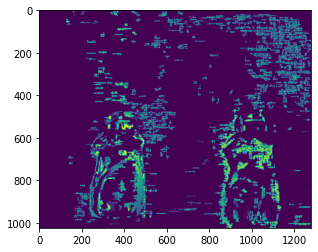

In [7]:
# parallax to depth
depth = np.ones_like(lookdispL , dtype=np.uint8)
for i in range(height):
    for j in range(width):
        if lookdispL[i][j]<5: ##noise
            depth[i][j]=0
        else:
            depth[i][j] = config.cam_matrix_left[0][0]*config.baseline/(lookdispL[i][j])
cv2.medianBlur(depth,3)
plt.imshow(depth)
